### SIDM with pyHalo

This notebook demonstrates how to generate realizations of self-interacting dark matter, in which a fraction of halos core collapse. 

In [2]:
from pyHalo.PresetModels.sidm import SIDM_core_collapse
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from lenstronomy.LensModel.lens_model import LensModel

### Fraction of collapsed halos as a function of halo mass

SIDM is parameterized in pyHalo through the fraction of collapsed halos as a function of halo mass. This was used by Gilman et al. (2023) to constrain SIDM cross sections https://ui.adsabs.harvard.edu/abs/2022arXiv220713111G/abstract. 

To use the SIDM_core_collapse preset model, you have to specify mass bins for both subhalos and field halos and the fraction of collapsed halos in each bin. In this implementation, halos have either collapsed (and therefore have a different density profile), or they have not collapsd (they have NFW profiles). 

There are two definitions of the collapsed density profile currently implemented. One is a cored power law
\begin{equation}
\rho\left(r, r_c, \gamma, \rho_0\right) = \rho_0 \left(1+\frac{r^2}{r_c^2}\right)^{-\gamma/2}
\end{equation}
The keyword arguments corrersponding to the parameters are $\gamma = $ log_slope_halo, $r_c = $ x_core_halo $\times \ r_s$ where $r_s$ is the scale radus of the original NFW profile, and $x_{\rm{match}}$ defines the normalization $\rho_0$ such that the new profile has the same mass enclosed within $x_{\rm{match}}$ as the original NFW profile. 

The other option (see below) is a "generalized NFW profile" 

\begin{equation}
\rho\left(r, r_s, \gamma_1, \gamma_2, \rho_0\right) = \rho_0 \left(\frac{r}{r_s}\right)^{-\gamma_1} \left(1 + \frac{r^2}{r_s^2}\right)^{\left(\gamma_1 - \gamma_2\right)/2}
\end{equation}
with a slope interior to $r_s$ of $\gamma_1$ ("gamma_inner"), a slope outside $r_s$ of $\gamma_2$ ("gamma_outer"), and $\rho_0$ again defined in terms of $x_{\rm{match}}$. 

### A note on cored halos

Previous code versions of pyHalo (release v1.0.0) supported cored density profiles as well as collapsed profiles. For the time being, I have omitted this option while I figure out the best way to implement them in the new code structure. 

In [3]:
zlens, zsource = 0.5, 2.0
mass_ranges_subhalos = [[6.0, 7.0], [7.0, 8.0], [8.0, 9.0], [9.0, 10.0]]
mass_ranges_fieldhalos = [[6.0, 7.5], [7.5, 8.5], [8.5, 10.0]]
collapse_fraction_subhalos = [0.9, 0.7, 0.5, 0.2]
collapse_fraction_fieldhalos = [0.3, 0.2, 0.1]

collapsed_halo_profile='SPL_CORE'
gamma = 3.0
# setting x_match = c means the collapsed halo will enclose the same mass inside the virial radius as the NFW profile
kwargs_collapsed_profile={'x_core_halo': 0.05, 'x_match': 'c', 'log_slope_halo': gamma}
realizationSIDM_1 = SIDM_core_collapse(zlens, zsource, 
                                       mass_ranges_subhalos, mass_ranges_fieldhalos, 
                                       collapse_fraction_subhalos, collapse_fraction_fieldhalos, 
                                       collapsed_halo_profile=collapsed_halo_profile,
                                       kwargs_collapsed_profile=kwargs_collapsed_profile,
                                       geometry_type='CYLINDER')

collapsed_halo_profile='GNFW'
gamma_1 = 2.2
gamma_2 = 3.0
kwargs_collapsed_profile={'gamma_inner': gamma_1, 'gamma_outer': gamma_2, 'x_match': 'c'}
realizationSIDM_2 = SIDM_core_collapse(zlens, zsource, 
                                       mass_ranges_subhalos, mass_ranges_fieldhalos, 
                                       collapse_fraction_subhalos, collapse_fraction_fieldhalos, 
                                       collapsed_halo_profile=collapsed_halo_profile,
                                       kwargs_collapsed_profile=kwargs_collapsed_profile,
                                       geometry_type='CYLINDER')


### Now we can compute the effective multiplane convergence with SIDM halos for the SPL_CORE model

In [4]:
lens_model_list, lens_redshift_array, kwargs_halos, numerical_deflection_class = realizationSIDM_1.lensing_quantities()
from lenstronomy.LensModel.lens_model import LensModel
# You should use the same astropy class created in pyhalo to do lensing computations
astropy_instance = realizationSIDM_1.astropy_instance
lens_model_halos_only = LensModel(lens_model_list, zlens, zsource, lens_redshift_array, cosmo=astropy_instance, multi_plane=True)

npix = 150 
grid_size = 1.4
_x = _y = np.linspace(-grid_size, grid_size, npix)
xx, yy = np.meshgrid(_x, _y)
shape0 = xx.shape

# power law plus shear macromodel
kwargs_macromodel = [{'theta_E': 1., 'center_x': 0., 'center_y': 0., 'e1': 0.2, 'e2': -0.1, 'gamma': 2.},
                    {'gamma1': -0.03, 'gamma2': 0.02}]

lens_model_list_macro = ['EPL', 'SHEAR']
lens_model_list_full = lens_model_list_macro + lens_model_list
lens_redshift_list_full = [zlens, zlens] + list(lens_redshift_array)
kwargs_lens_full = kwargs_macromodel + kwargs_halos

lens_model_full = LensModel(lens_model_list_full, zlens, zsource, 
                            lens_redshift_list_full, cosmo=astropy_instance, multi_plane=True, 
                            numerical_alpha_class=numerical_deflection_class)
lens_model_macro = LensModel(lens_model_list_macro)

kappa_full = lens_model_full.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full).reshape(shape0)
kappa_macro = lens_model_macro.kappa(xx.ravel(), yy.ravel(), kwargs_macromodel).reshape(shape0)

from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
lens_model_extension = LensModelExtensions(lens_model_full)
grid_resolution = 0.02 # this can take a while for higher resolution computations of the critical curves
ra_crit_list, dec_crit_list, _, _ = lens_model_extension.critical_curve_caustics(kwargs_lens_full, 
                                                                compute_window=2*grid_size, grid_scale=grid_resolution)

### Make the figure

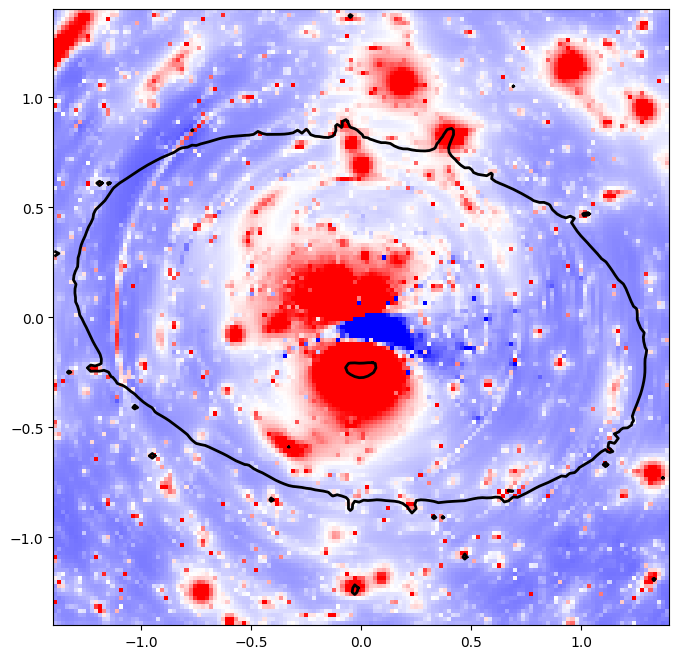

In [5]:
fig = plt.figure(1)
fig.set_size_inches(8,8)
kappa_subs_nonlinear_spl = kappa_full - kappa_macro

# subtracting the mean can make halos appear more clearly 
mean = np.mean(kappa_subs_nonlinear_spl)
plt.imshow(kappa_subs_nonlinear_spl - mean, vmin=-0.05, vmax=0.05, cmap='bwr', extent=[-grid_size, grid_size, -grid_size, grid_size], origin='lower')

for i in range(0, len(ra_crit_list)):
    plt.plot(ra_crit_list[i], dec_crit_list[i], color='k', lw=2)



In [6]:
lens_model_list, lens_redshift_array, kwargs_halos, numerical_deflection_class = realizationSIDM_2.lensing_quantities()

from lenstronomy.LensModel.lens_model import LensModel
# You should use the same astropy class created in pyhalo to do lensing computations
astropy_instance = realizationSIDM_2.astropy_instance
lens_model_halos_only = LensModel(lens_model_list, zlens, zsource, lens_redshift_array, cosmo=astropy_instance, multi_plane=True)

npix = 150 
grid_size = 1.4
_x = _y = np.linspace(-grid_size, grid_size, npix)
xx, yy = np.meshgrid(_x, _y)
shape0 = xx.shape

# power law plus shear macromodel
kwargs_macromodel = [{'theta_E': 1., 'center_x': 0., 'center_y': 0., 'e1': 0.2, 'e2': -0.1, 'gamma': 2.},
                    {'gamma1': -0.03, 'gamma2': 0.02}]

lens_model_list_macro = ['EPL', 'SHEAR']
lens_model_list_full = lens_model_list_macro + lens_model_list
lens_redshift_list_full = [zlens, zlens] + list(lens_redshift_array)
kwargs_lens_full = kwargs_macromodel + kwargs_halos

lens_model_full = LensModel(lens_model_list_full, zlens, zsource, 
                            lens_redshift_list_full, cosmo=astropy_instance, multi_plane=True, 
                            numerical_alpha_class=numerical_deflection_class)
lens_model_macro = LensModel(lens_model_list_macro)

kappa_full = lens_model_full.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full).reshape(shape0)
kappa_macro = lens_model_macro.kappa(xx.ravel(), yy.ravel(), kwargs_macromodel).reshape(shape0)

from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
lens_model_extension = LensModelExtensions(lens_model_full)
grid_resolution = 0.02 # this can take a while for higher resolution computations of the critical curves
ra_crit_list, dec_crit_list, _, _ = lens_model_extension.critical_curve_caustics(kwargs_lens_full, 
                                                                compute_window=2*grid_size, grid_scale=grid_resolution)

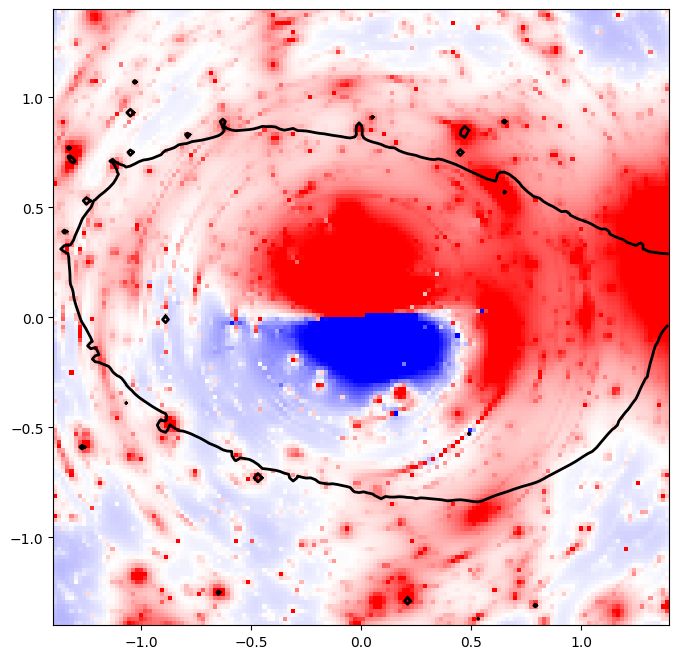

In [7]:
fig = plt.figure(1)
fig.set_size_inches(8,8)
kappa_subs_nonlinear_gnfw = kappa_full - kappa_macro

# subtracting the mean can make halos appear more clearly 
mean = np.mean(kappa_subs_nonlinear_spl)
plt.imshow(kappa_subs_nonlinear_gnfw - mean, vmin=-0.05, vmax=0.05, cmap='bwr', extent=[-grid_size, grid_size, -grid_size, grid_size], origin='lower')

for i in range(0, len(ra_crit_list)):
    plt.plot(ra_crit_list[i], dec_crit_list[i], color='k', lw=2)

